# Прогнозирование

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels. tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from google.colab import drive
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Курсач/DForecast2.xlsx'
df = pd.read_excel(path, engine="openpyxl")

df = df.set_index('Дата')

df.index = pd.to_datetime(df.index)
#df = df["PBW"]
df["Time"] = range(1, 231)
df = df.round(2)
df.head()

,PBW,Time
Дата,,
2005-04-01,64.25,1
2005-05-01,67.60,2
2005-06-01,73.05,3
2005-07-01,79.25,4
2005-08-01,86.10,5


Text(0, 0.5, 'PBW')

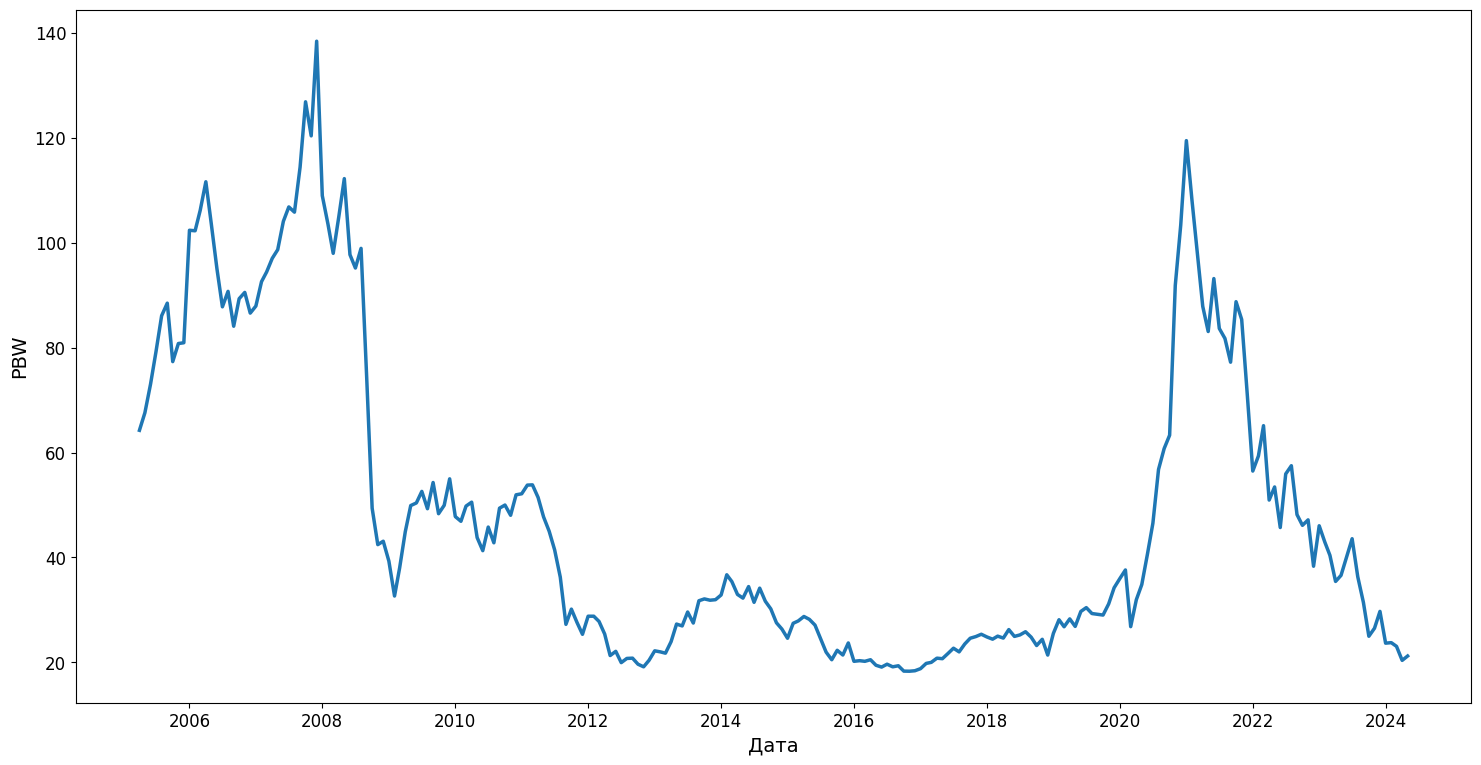

In [ ]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(18, 9))
# Увеличение толщины линии на графике
ax.plot(df.index, df["PBW"], linewidth=2.5)

# Настройка размера шрифта надписей по осям
ax.set_xlabel("Дата", fontsize=16)
ax.set_ylabel("PBW", fontsize=16)

# Увеличение размера цифр на осях
ax.tick_params(axis='both', which='major', labelsize=12)
# Построение временного ряда

# Настройка осей и легенды
ax.set_xlabel("Дата", fontsize=14)
ax.set_ylabel("PBW", fontsize=14)

In [ ]:
# Тест ADF
result = adfuller(df["PBW"]) # taking into account constant and trend
print('ADF Statistic: %.4f' % round(result[0], 4))
print('p-value: %.4f' % round(result[1], 4))
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

In [ ]:
df_t = df.copy()
df_t[['PBW']] = df_t[['PBW']].diff(periods=1)
df_t = df_t.dropna()
df_t.head()

,PBW,Time,Trend,Detrend
Дата,,,,
2005-05-01,3.35,2,69.743128,-2.143128
2005-06-01,5.45,3,69.553809,3.496191
2005-07-01,6.20,4,69.364491,9.885509
2005-08-01,6.85,5,69.175172,16.924828
2005-09-01,2.40,6,68.985853,19.514147


In [ ]:
# Тест ADF
result = adfuller(df_t["PBW"])
print('ADF Statistic: %.4f' % round(result[0], 4))
print('p-value: %.4f' % round(result[1], 4))
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

In [ ]:
# PACF and ACF
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# График автокорреляционной функции
sm.graphics.tsa.plot_acf(df_t["PBW"].values.squeeze(), lags=20, ax=axs[0])
axs[0].set_title('Autocorrelation Function')

# График частичной автокорреляционной функции
sm.graphics.tsa.plot_pacf(df_t["PBW"].values.squeeze(), lags=20, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [ ]:
# BIC and AIC
param_grid = [(p1, 1, p3) for p1, p3 in product(range(0, 3), repeat=2)]
results = []

min_bic = float('inf')
min_aic = float('inf')

for p, d, q in param_grid:
    model_arima = ARIMA(df_t["PBW"], order=(p, d, q))
    result_arima = model_arima.fit()

    bic = result_arima.bic
    aic = result_arima.aic

    if bic < min_bic:
        min_bic = bic
    if aic < min_aic:
        min_aic = aic

    results.append([(p, d, q), bic, aic])

df_results = pd.DataFrame(results, columns=['Model Parameters', 'BIC', 'AIC'])


def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

# Applying the function to the DataFrame
styled_df = df_results.style.format({'BIC': '{:.2f}', 'AIC': '{:.2f}'}) \
                        .apply(highlight_min, subset=['BIC', 'AIC'])

# Displaying the table with marked minimum values
display(styled_df)

In [ ]:
# Обучение лучшей модели ARIMA
model_best = ARIMA(df["PBW"], order=(0, 1, 1))
result_best = model_best.fit()

forecast = result_best.forecast(steps=1)

future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=1, freq='M')

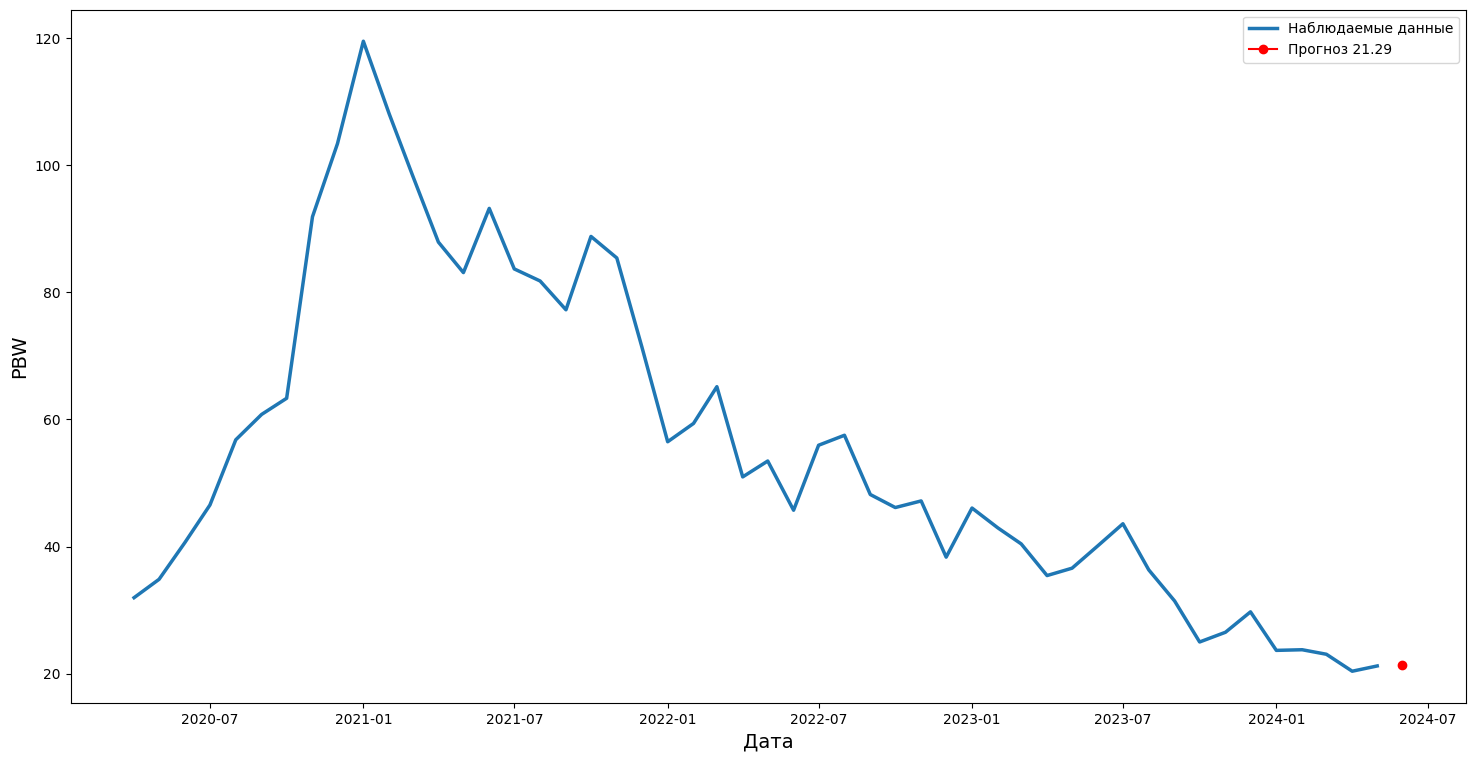

In [ ]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(18, 9))

# Построение временного ряда
ax.plot(df.index[180:], df["PBW"].iloc[180:], linewidth=2.5, label="Наблюдаемые данные")

# Построение прогноза
ax.plot(future_index, forecast, color='red', marker='o', label='Прогноз 21.29')

# Настройка осей и легенды
ax.set_xlabel("Время")
ax.set_ylabel("PBW")
#ax.set_title("Временной ряд и прогноз")
ax.legend()
ax.set_xlabel("Дата", fontsize=14)
ax.set_ylabel("PBW", fontsize=14)
# Отображение графика
plt.show()

In [ ]:
# Описание модели
model_best = ARIMA(df["PBW"], order=(0, 1, 1))
result_best = model_best.fit()
print(result_best.summary())